#Set-up

We install some packages, connect to drive and set the seed. Feel free to ignore

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install transformers

Mounted at /content/drive


In [2]:
# set seeds
import random
import numpy as np
import torch

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

set_seed(42)

# Comparing probe weights to SAE weights

If a linear probe learns to detect annotation A and we have an SAE latent who does too, we would expect the linear probe weights to align with the decoder row of the SAE latent. Thats because TODO

## Set-up & Load SAE

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

cfg = {
    "seed": 49,
    "batch_size": 4096*6,
    "buffer_mult": 384,
    "lr": 5e-5,
    #"num_tokens": tokenizer_nt.vocab_size,
    "d_model": 512,
    "l1_coeff": 1e-1,
    "beta1": 0.9,
    "beta2": 0.999,
    "dict_mult": 8, # hidden_d = d_model * dict_mult
    "seq_len": 512,
    "d_mlp": 512,
    "enc_dtype":"fp32",
    "remove_rare_dir": False,
    "total_training_steps": 10000,
    "lr_warm_up_steps": 1000,
    "device": "cuda"
}

cfg["model_batch_size"] = 64
cfg["buffer_size"] = cfg["batch_size"] * cfg["buffer_mult"]
cfg["buffer_batches"] = cfg["buffer_size"] // cfg["seq_len"]

DTYPES = {"fp32": torch.float32, "fp16": torch.float16, "bf16": torch.bfloat16}

class AutoEncoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # HP-choices
        d_hidden = cfg["d_mlp"] * cfg["dict_mult"]
        d_mlp = cfg["d_mlp"]
        self.l0_coeff = cfg.get("l0_coeff", 5)
        self.threshold = cfg.get("activation_threshold", 0.3)
        # Temperature for sigmoid approximation
        self.temperature = cfg.get("temperature", 1.0)
        dtype = DTYPES[cfg["enc_dtype"]]
        torch.manual_seed(cfg["seed"])

        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_mlp, d_hidden, dtype=dtype)))
        self.W_dec = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_hidden, d_mlp, dtype=dtype)))
        self.b_enc = nn.Parameter(torch.zeros(d_hidden, dtype=dtype))
        self.b_dec = nn.Parameter(torch.zeros(d_mlp, dtype=dtype))
        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)

        self.d_hidden = d_hidden
        self.to("cuda") if torch.cuda.is_available() else self.to("cpu")

    def get_continuous_l0(self, x):
        """
        Compute continuous relaxation of L0 norm using sigmoid
        This provides useful gradients unlike the discrete L0
        """
        # Shifted sigmoid to approximate step function
        return torch.sigmoid((x.abs() - self.threshold) / self.temperature)

    def forward(self, x):
        # encoding and decoding of input vec
        x_cent = x - self.b_dec
        pre_acts = x_cent @ self.W_enc + self.b_enc
        acts = F.relu(pre_acts)

        # Compute continuous L0 approximation before thresholding
        l0_proxy = self.get_continuous_l0(acts)

        # Apply hard threshold for forward pass --- This is actually jumprelu (I think!)
        acts_sparse = (acts.abs() > self.threshold).float() * acts
        x_reconstruct = acts_sparse @ self.W_dec + self.b_dec

        # L2 Loss (Reconstruction Loss)
        l2_loss = F.mse_loss(x_reconstruct.float(), x.float(), reduction='none')
        l2_loss = l2_loss.sum(-1)
        l2_loss = l2_loss.mean()

        # Normalized MSE for reporting
        nmse = torch.norm(x - x_reconstruct, p=2) / torch.norm(x, p=2)

        # Continuous L0 loss (using sigmoid approximation)
        l0_loss = l0_proxy.sum(dim=1).mean()

        # Total Loss: reconstruction + sparsity
        loss = l2_loss + self.l0_coeff * l0_loss

        # For monitoring: true L0 count (not used in optimization)
        true_l0 = (acts_sparse.float().abs() > 0).float().sum(dim=1).mean()

        # For monitoring: L1 loss
        l1_loss = acts_sparse.float().abs().sum(-1).mean()

        return loss, x_reconstruct, acts_sparse, l2_loss, nmse, l1_loss, true_l0

    @torch.no_grad()
    def remove_parallel_component_of_grads(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj


## Load already-trained SAE

In [4]:
weights_path = "/content/drive/MyDrive/SAEs_for_Genomics/Weights/nt50m_sae_+40mtokens.pt"
state_dict = torch.load(weights_path)
sae_model = AutoEncoder(cfg)
sae_model.load_state_dict(state_dict)

weights_path_2 = "/content/drive/MyDrive/SAEs_for_Genomics/NT50_L5.mlp_SAE_48mtokens.pt"
#cfg['dict_mult'] = 16
sae_model_2 = AutoEncoder(cfg)
state_dict_2 = torch.load(weights_path_2)['model_state_dict']
sae_model_2.load_state_dict(state_dict_2)



<ipython-input-4-0879ffb89aad>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path)
<ipython-input-4-0879ffb89aad>:9: FutureWarning: You ar

<All keys matched successfully>

### Test: which decoder rows are most simialr

In [16]:
import torch
import tqdm


def compare_sae_decoder_weights(sae_model, sae_model2):
    # Move decoder weights to GPU
    sae_decoder_weights = sae_model.W_dec.cuda()
    sae_decoder_weights2 = sae_model2.W_dec.cuda()

    # Normalize decoder weights to get unit vectors for cosine similarity
    norms = torch.norm(sae_decoder_weights, dim=1, keepdim=True)
    normalized_weights = sae_decoder_weights / norms

    norms2 = torch.norm(sae_decoder_weights2, dim=1, keepdim=True)
    normalized_weights2 = sae_decoder_weights2 / norms2

    # Compute cosine similarity matrix using matrix multiplication
    cosine_sim_matrix = torch.mm(normalized_weights, normalized_weights2.t())

    return cosine_sim_matrix



cosine_sim_matrix = compare_sae_decoder_weights(sae_model, sae_model_2)

# To avoid self-similarity, set the diagonal to -1
#cosine_sim_matrix.fill_diagonal_(-1)

# Get indices of pairs with similarity > 0.3
similar_pairs = torch.nonzero(cosine_sim_matrix > 0.3, as_tuple=True)

pbar = tqdm.tqdm(total=len(similar_pairs[0]))


# control lets reinit
sae_model_random = AutoEncoder(cfg)
sae_model_random_2 = AutoEncoder(cfg)


cosine_sim_matrix = compare_sae_decoder_weights(sae_model_random_2, sae_model_random)

# To avoid self-similarity, set the diagonal to -1
# cosine_sim_matrix.fill_diagonal_(-1)

similar_pairs_rand = torch.nonzero(cosine_sim_matrix > 0.7, as_tuple=True)

print(f"Number of similar pairs: {len(similar_pairs[0])}")
print(f"Number of similar pairs random: {len(similar_pairs_rand[0])}")

pbar = tqdm.tqdm(total=len(similar_pairs[0]))

"""
for i, j in zip(similar_pairs[0].cpu().numpy(), similar_pairs[1].cpu().numpy()):
    pbar.update(1)
    print(f"Similarity between rows {i} and {j}: {cosine_sim_matrix[i, j].item()}")
    print()
"""

0it [00:00, ?it/s]

Number of similar pairs: 0
Number of similar pairs random: 4096




0it [00:00, ?it/s]


'\nfor i, j in zip(similar_pairs[0].cpu().numpy(), similar_pairs[1].cpu().numpy()):\n    pbar.update(1)\n    print(f"Similarity between rows {i} and {j}: {cosine_sim_matrix[i, j].item()}")\n    print()\n'

### Test: use decoder rows as linear probes

In [ ]:
# get decoder column 946
sae_decoder_weights = sae_model.W_dec.cpu().detach().numpy()
sae_encoder_weights = sae_model.W_enc.cpu().detach().numpy()
print(sae_encoder_weights.shape)
print(sae_decoder_weights.shape)
sae_decoder_weights[946,:].shape

(512, 4096)
(4096, 512)


(512,)

In [ ]:

# set weights and bias of model
model.weight.data = torch.from_numpy(sae_decoder_weights[946,:].reshape(1, -1))
model.bias.data = torch.tensor(-5.0)
model.cuda()


# For each annotation experiment:
annotation = 'PuroR' ## the annotation that the SAE latent is monosemantic for
print("Processing annotation:", annotation)

result = process_annotation(
    df=token_df_1k_s0,
    xs=xs,
    annotation=annotation,
    target_value='TATA'
)
x_tensor = result['features']
y_tensor = result['labels']


address_imbalance = True
if address_imbalance:
    # Calculate class weights based on inverse frequency
    n_samples = len(y_tensor)
    n_positive = y_tensor.sum()
    pos_weight = (n_samples - n_positive) / n_positive

results = trainer.evaluate(x_tensor, y_tensor)


PuroR
Baserate accuracy: 0.9949558933933934
Validation Accuracy: 0.9950, Best Precision: 0.5172, Best Recall: 0.0581, Best F1: 0.1045


## Analyse SAE encoder ~ SAE decoder weights

(512, 4096)
(4096, 512)


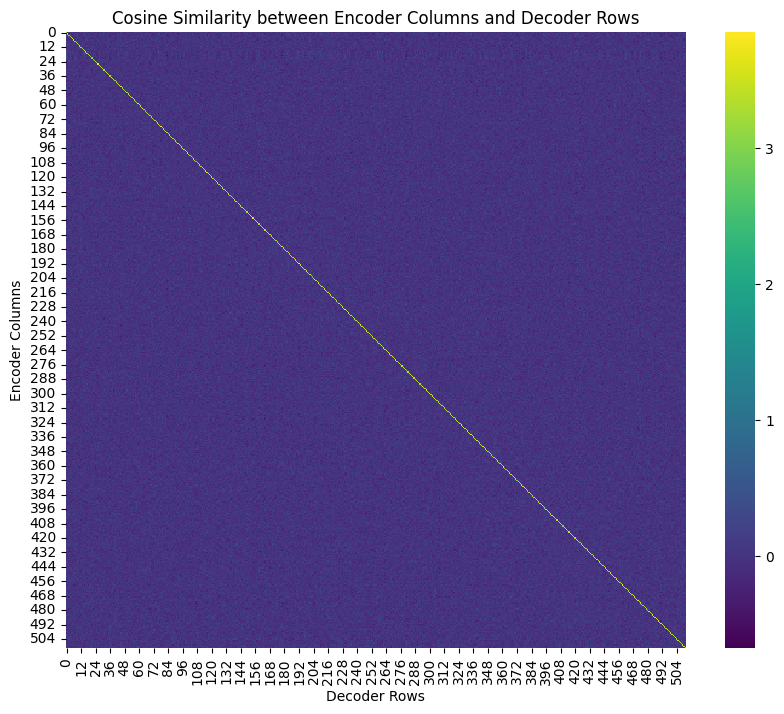

In [ ]:
sae_encoder_weights = sae_model.W_enc.cpu().detach().numpy()
sae_decoder_weights = sae_model.W_dec.cpu().detach().numpy()
print(sae_encoder_weights.shape)
print(sae_decoder_weights.shape)


# compute the cosine similarity of each i-th column vec in encoder and i-th row vector in decoder
dot_products_enc = np.dot(sae_encoder_weights, sae_decoder_weights)
cosine_sims_enc = dot_products_enc/(np.linalg.norm(sae_encoder_weights, axis=1) * np.linalg.norm(sae_decoder_weights, axis=0))

# plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sims_enc, cmap='viridis', annot=False)
plt.title("Cosine Similarity between Encoder Columns and Decoder Rows")
plt.xlabel("Decoder Rows")
plt.ylabel("Encoder Columns")
plt.show()






In [ ]:
# get max cosine_sim_enc value

max_cosine_sim_enc = cosine_sims_enc.max()
max_cosine_sim_decoder = cosine_sims_decoder.max()

# get index (sea latent) for each
max_cosine_sim_enc_idx = np.argmax(cosine_sims_enc)
max_cosine_sim_decoder_idx = np.argmax(cosine_sims_decoder)

print("Max cosine similarity:", max_cosine_sim_enc)
print("Max cosine similarity decoder:", max_cosine_sim_decoder)
print("Max cosine similarity index:", max_cosine_sim_enc_idx)
print("Max cosine similarity index decoder:", max_cosine_sim_decoder_idx)

Max cosine similarity: 0.13455886
Max cosine similarity decoder: 0.15733886
Max cosine similarity index: 3928
Max cosine similarity index decoder: 4023
